# Pre Processing


## Import Libraries

In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.4.0'

## Download DataSet

- 2,000 JPG pictures of cats and dogs

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-01-11 23:48:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  81.6MB/s    in 0.8s    

2021-01-11 23:48:10 (81.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Unzip Files

In [5]:
datasetPath = '/tmp/cats_and_dogs_filtered.zip' 

In [6]:
zip_object = zipfile.ZipFile(file=datasetPath,mode='r')

In [7]:
zip_object.extractall('./')

In [8]:
zip_object.close()

### Configure Paths

In [11]:
dataset_dir = '/content/cats_and_dogs_filtered'

In [12]:
train_dir = os.path.join(dataset_dir,'train')

In [13]:
validation_dir = os.path.join(dataset_dir,'validation')

In [18]:
print(train_dir,validation_dir)

/content/cats_and_dogs_filtered/train /content/cats_and_dogs_filtered/validation


## Model Construct

### Load Pre Trained Model (MobileNetV2)

In [20]:
img_shape = (128,128,3) #128x128 #RGB

Include top = False (Not use output Layer)

In [22]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,include_top=False,weights='imagenet')

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Freeze Model

In [24]:
base_model.trainable = False #Neither Weight will be updated

### Customized Header


In [25]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

Reduce Layer by Global Average

[Global Average](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/)

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [27]:
global_average_layer


<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [28]:
prediction_layer = tf.keras.layers.Dense(units=1,activation='sigmoid')(global_average_layer)

## Define Model

### Union 2 parts (Freeze Model + Customized Header)
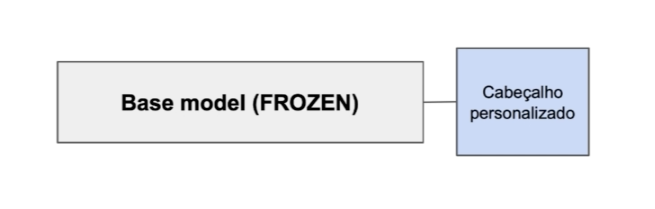


In [30]:
model = tf.keras.models.Model(inputs = base_model.input,outputs=prediction_layer)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

## Compile Model

In [33]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),\
              loss='binary_crossentropy',metrics=['accuracy'])

## Data Generators

Mobile Net Supports = (96,96) (128,128) (160,160) (192,192) (224,224)

In [34]:
data_gen_train = ImageDataGenerator(rescale=1/255.0)
data_gen_valid = ImageDataGenerator(rescale=1/255.0)

In [37]:
train_generator = data_gen_train.flow_from_directory(train_dir,target_size=(128,128),batch_size=128,class_mode='binary')
valid_generator = data_gen_valid.flow_from_directory(validation_dir,target_size=(128,128),batch_size=128,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Training

In [39]:
model.fit(train_generator,epochs=5,validation_data=valid_generator)

Epoch 1/5
16/16 [==============================] - 8s 500ms/step - loss: 0.3544 - accuracy: 0.8705 - val_loss: 0.3552 - val_accuracy: 0.8750
Epoch 2/5
16/16 [==============================] - 8s 489ms/step - loss: 0.3176 - accuracy: 0.8870 - val_loss: 0.3202 - val_accuracy: 0.8970
Epoch 3/5
16/16 [==============================] - 8s 496ms/step - loss: 0.2871 - accuracy: 0.8980 - val_loss: 0.2909 - val_accuracy: 0.9100
Epoch 4/5
16/16 [==============================] - 8s 482ms/step - loss: 0.2622 - accuracy: 0.9100 - val_loss: 0.2670 - val_accuracy: 0.9190
Epoch 5/5
16/16 [==============================] - 8s 490ms/step - loss: 0.2409 - accuracy: 0.9155 - val_loss: 0.2463 - val_accuracy: 0.9250


## Evaluate

In [40]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)

8/8 [==============================] - 3s 311ms/step - loss: 0.2463 - accuracy: 0.9250


In [41]:
valid_accuracy

0.925000011920929

# Fine Tuning

Fine tuning later than Transfer Learning


## Unfreeze some layers from top

In [42]:
base_model.trainable = True

In [44]:
len(base_model.layers) # 155 Layers

154

### Freeze 0-100
trainable = False

In [45]:
fine_tuning_at = 100

In [46]:
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

## Complie Model

In [49]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

## Fine Tuning


In [59]:
history = model.fit(train_generator,epochs=5,validation_data=valid_generator)

Epoch 1/5
16/16 [==============================] - 8s 509ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1687 - val_accuracy: 0.9630
Epoch 2/5
16/16 [==============================] - 8s 492ms/step - loss: 2.6670e-04 - accuracy: 1.0000 - val_loss: 0.1725 - val_accuracy: 0.9650
Epoch 3/5
16/16 [==============================] - 8s 489ms/step - loss: 2.8889e-04 - accuracy: 1.0000 - val_loss: 0.1270 - val_accuracy: 0.9720
Epoch 4/5
16/16 [==============================] - 8s 500ms/step - loss: 3.2537e-04 - accuracy: 1.0000 - val_loss: 0.1437 - val_accuracy: 0.9740
Epoch 5/5
16/16 [==============================] - 8s 490ms/step - loss: 9.5273e-05 - accuracy: 1.0000 - val_loss: 0.1840 - val_accuracy: 0.9670


In [64]:
print(history.history)

{'loss': [0.00122860970441252, 0.0002667045337148011, 0.00028889180975966156, 0.0003253710165154189, 9.527322254143655e-05], 'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.16873259842395782, 0.17252004146575928, 0.1269635111093521, 0.1436709463596344, 0.18404749035835266], 'val_accuracy': [0.9629999995231628, 0.9649999737739563, 0.972000002861023, 0.9739999771118164, 0.9670000076293945]}


## Evaluate Fine Tuning

In [65]:
valid_loss, valid_accuracy = model.evaluate(valid_generator)

8/8 [==============================] - 3s 316ms/step - loss: 0.1840 - accuracy: 0.9670


In [66]:
valid_loss

0.18404749035835266

In [67]:
valid_accuracy

0.9670000076293945